In [2]:
import numpy as np
import pandas as pd
import os, re, time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import tensorflow as tf
from tensorflow import keras

In [3]:
from keras import layers
from keras.callbacks import TensorBoard

from keras.models import Sequential, Model

from keras.layers import LSTM, Dense, Dropout, Embedding, Input, Activation, GRU, Convolution1D, Flatten, LeakyReLU
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalAveragePooling1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import SpatialDropout1D, MaxPooling1D, Bidirectional, GRU, concatenate

from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

from keras.utils import pad_sequences

from collections import OrderedDict

from keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [4]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [5]:
from multiprocessing import cpu_count
print(cpu_count())

8


In [6]:
!mkdir -p /home/jupyter/data/wordvec/

In [7]:
!gsutil cp -n 'gs://msca-bdp-data-open/wordvec/glove.6B.100d.txt' '/home/jupyter/data/wordvec/'

Skipping existing item: file:///home/jupyter/data/wordvec/glove.6B.100d.txt


In [8]:
mob_load = pd.read_csv("mobile__multi_sent.csv")

In [9]:
mob_load['sentiment'].value_counts()

 1    52197
 0    35080
-1    17572
Name: sentiment, dtype: int64

In [10]:
#Column with clean text
textVar = mob_load["text"]

#Target columns (sentiment, class, etc.)
targetVar = mob_load["sentiment"]

In [11]:
targetVar.nunique()

3

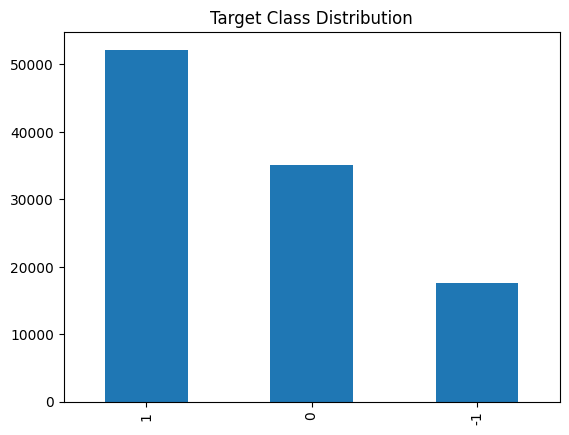

In [12]:
countClasses = pd.value_counts(targetVar.values, sort=True)
countClasses.plot.bar(legend=None, title="Target Class Distribution")
plt.show()

In [13]:
# make our experiments repeatable
np.random.seed(0)

# Model Hyperparameters
embedding_dim = 100

# Here we specify the number of units of our RNN layer
lstm_dims = 196

# Training parameters. Here we specify the training of the net will use N examples for each backprop iteration
batch_size = 64

# We will go thru the entire data set N times
num_epochs = 10

# Prepossessing parameters
# We will only input the first "sequence_length" words of every Yelp review (and pad out with nulls if the text is < "sequence_length
# We will also build our model using the most frequent 20000 words in our tweet 'dictionary'
sequence_length = 200
max_features = 20000

#Specify the number of classes to predict (1 for binary classification or count unique values for multilabel classification)
#num_classes = 1
num_classes = targetVar.nunique()

In [14]:
# encoder = preprocessing.LabelEncoder()
# encoder.fit(targetVar)

X = textVar.values
Y = pd.get_dummies(targetVar).values

In [15]:
train_samples, val_samples, train_labels, val_labels = train_test_split(X,Y, stratify=targetVar, test_size = 0.33, random_state = 0)

In [16]:
# Check how many columns we have, make sure we have our sequence length set correctly

print(train_samples.shape,train_labels.shape)
print(val_samples.shape,val_labels.shape)

(70248,) (70248, 3)
(34601,) (34601, 3)


In [17]:
vectorizer = TextVectorization(max_tokens=max_features, output_sequence_length=sequence_length, ngrams=None, pad_to_max_tokens=True)

text_ds = tf.data.Dataset.from_tensor_slices(train_samples).batch(128)
vectorizer.adapt(text_ds)

2023-05-24 23:06:38.795877: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-24 23:06:38.807592: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-24 23:06:38.807865: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-24 23:06:38.808913: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [18]:
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'the', 'i', 'it']

In [19]:
X_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
X_test = vectorizer(np.array([[s] for s in val_samples])).numpy()

Y_train = np.array(train_labels)
Y_test = np.array(val_labels)

### Load the pretrained vector space model

GloVe embedding data can be found at:

http://nlp.stanford.edu/data/glove.6B.zip

(source page: http://nlp.stanford.edu/projects/glove/)

* For Tweets we shall use data trained on Twitter (2B tweets, 27B tokens, 1.2M vocab)
* For non-Twitter data Gigaword would be a better choice (6B tokens, 400K vocab).  

Gigaword -  is a comprehensive archive of newswire text data that has been acquired over several years by the LDC at the University of Pennsylvania. The fifth edition includes all of the contents in English Gigaword Fourth Edition (LDC2009T13) plus new data covering the 24-month period of January 2009 through December 2010.

In [20]:
embeddings_index = {}

glove_dir = '/home/jupyter/data/wordvec/'
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [21]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [22]:
num_tokens = len(voc) + 2
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 15572 words (4428 misses)


In [23]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [24]:
sequence_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(sequence_input)

x = LSTM(lstm_dims, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(units = 3, activation="softmax")(x)


model = Model(sequence_input, preds)
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         2000200   
                                                                 
 lstm_layer (LSTM)           (None, None, 196)         232848    
                                                                 
 global_max_pooling1d (Globa  (None, 196)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 196)               0         
                                                                 
 dense (Dense)               (None, 50)                9850      
                                                             

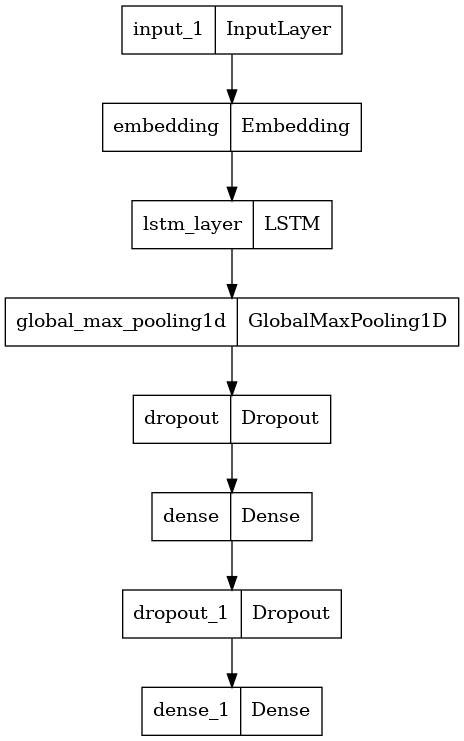

In [25]:
tf.keras.utils.plot_model(model)

In [26]:
filepath="/home/jupyter/data/dl_models/gru_glove_weights_best"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',
                             verbose=1, save_best_only=True, save_weights_only=False, overwrite=True, mode='max')
#only save model if it improves the accuracy

callbacks_list = [checkpoint]

t1 = time.time()
history = model.fit(X_train, Y_train,
                    batch_size=batch_size, 
                    epochs=num_epochs,
                    validation_data=(X_test, Y_test),
                    callbacks = callbacks_list,
                    verbose=1)
t2 = time.time()
print("GRU Glove model train time = %d seconds" %(t2-t1))

GRU_glove_history = history

Epoch 1/10


2023-05-24 23:06:58.118144: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


1096/1098 [============================>.] - ETA: 0s - loss: 0.6048 - accuracy: 0.7267
Epoch 1: val_accuracy improved from -inf to 0.77082, saving model to /home/jupyter/data/dl_models/gru_glove_weights_best


INFO:tensorflow:Assets written to: /home/jupyter/data/dl_models/gru_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/data/dl_models/gru_glove_weights_best/assets


1098/1098 [==============================] - 40s 34ms/step - loss: 0.6045 - accuracy: 0.7268 - val_loss: 0.5166 - val_accuracy: 0.7708
Epoch 2/10
1096/1098 [============================>.] - ETA: 0s - loss: 0.4895 - accuracy: 0.7864
Epoch 2: val_accuracy improved from 0.77082 to 0.79223, saving model to /home/jupyter/data/dl_models/gru_glove_weights_best


INFO:tensorflow:Assets written to: /home/jupyter/data/dl_models/gru_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/data/dl_models/gru_glove_weights_best/assets


1098/1098 [==============================] - 36s 33ms/step - loss: 0.4895 - accuracy: 0.7864 - val_loss: 0.4751 - val_accuracy: 0.7922
Epoch 3/10
1098/1098 [==============================] - ETA: 0s - loss: 0.4608 - accuracy: 0.8014
Epoch 3: val_accuracy did not improve from 0.79223
1098/1098 [==============================] - 19s 17ms/step - loss: 0.4608 - accuracy: 0.8014 - val_loss: 0.4806 - val_accuracy: 0.7868
Epoch 4/10
1097/1098 [============================>.] - ETA: 0s - loss: 0.4383 - accuracy: 0.8122
Epoch 4: val_accuracy improved from 0.79223 to 0.79790, saving model to /home/jupyter/data/dl_models/gru_glove_weights_best


INFO:tensorflow:Assets written to: /home/jupyter/data/dl_models/gru_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/data/dl_models/gru_glove_weights_best/assets


1098/1098 [==============================] - 36s 33ms/step - loss: 0.4383 - accuracy: 0.8122 - val_loss: 0.4650 - val_accuracy: 0.7979
Epoch 5/10
1095/1098 [============================>.] - ETA: 0s - loss: 0.4206 - accuracy: 0.8209
Epoch 5: val_accuracy improved from 0.79790 to 0.79992, saving model to /home/jupyter/data/dl_models/gru_glove_weights_best


INFO:tensorflow:Assets written to: /home/jupyter/data/dl_models/gru_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/data/dl_models/gru_glove_weights_best/assets


1098/1098 [==============================] - 34s 31ms/step - loss: 0.4203 - accuracy: 0.8210 - val_loss: 0.4634 - val_accuracy: 0.7999
Epoch 6/10
1095/1098 [============================>.] - ETA: 0s - loss: 0.4041 - accuracy: 0.8273
Epoch 6: val_accuracy did not improve from 0.79992
1098/1098 [==============================] - 19s 17ms/step - loss: 0.4043 - accuracy: 0.8273 - val_loss: 0.4595 - val_accuracy: 0.7986
Epoch 7/10
1096/1098 [============================>.] - ETA: 0s - loss: 0.3837 - accuracy: 0.8371
Epoch 7: val_accuracy improved from 0.79992 to 0.80371, saving model to /home/jupyter/data/dl_models/gru_glove_weights_best


INFO:tensorflow:Assets written to: /home/jupyter/data/dl_models/gru_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/data/dl_models/gru_glove_weights_best/assets


1098/1098 [==============================] - 36s 32ms/step - loss: 0.3840 - accuracy: 0.8370 - val_loss: 0.4578 - val_accuracy: 0.8037
Epoch 8/10
1095/1098 [============================>.] - ETA: 0s - loss: 0.3663 - accuracy: 0.8454
Epoch 8: val_accuracy did not improve from 0.80371
1098/1098 [==============================] - 19s 17ms/step - loss: 0.3664 - accuracy: 0.8454 - val_loss: 0.4675 - val_accuracy: 0.7992
Epoch 9/10
1097/1098 [============================>.] - ETA: 0s - loss: 0.3514 - accuracy: 0.8509
Epoch 9: val_accuracy did not improve from 0.80371
1098/1098 [==============================] - 20s 19ms/step - loss: 0.3514 - accuracy: 0.8508 - val_loss: 0.4787 - val_accuracy: 0.7983
Epoch 10/10
1097/1098 [============================>.] - ETA: 0s - loss: 0.3326 - accuracy: 0.8614
Epoch 10: val_accuracy did not improve from 0.80371
1098/1098 [==============================] - 19s 17ms/step - loss: 0.3326 - accuracy: 0.8614 - val_loss: 0.4850 - val_accuracy: 0.8005
GRU Glove m

In [27]:
!ls -l "/home/jupyter/data/dl_models/gru_glove_weights_best"

total 102980
drwxr-xr-x 2 jupyter jupyter      4096 May 22 08:09 assets
-rw-r--r-- 1 jupyter jupyter 104631010 May 24 23:10 keras_metadata.pb
-rw-r--r-- 1 jupyter jupyter    810775 May 24 23:10 saved_model.pb
drwxr-xr-x 2 jupyter jupyter      4096 May 24 23:10 variables


In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [29]:
def plot_train(history):
    """
    Plot the keras epoch results thru training
    """
    h = history.history
    epochs = range(1, len(h['accuracy']) + 1)
    plt.plot(epochs, h['accuracy'], 'orange', label='Training acc')
    plt.plot(epochs, h['val_accuracy'], 'blue', label='Validation acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

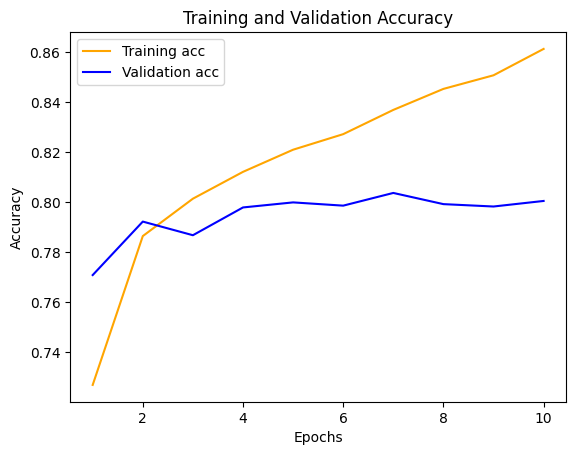

In [30]:
plot_train(GRU_glove_history)

In [31]:
def plot_loss(history):
    """
    Plot the keras epoch results thru training
    """
    h = history.history
    epochs = range(1, len(h['accuracy']) + 1)
    plt.plot(epochs, h['loss'], 'orange', label='Training loss')
    plt.plot(epochs, h['val_loss'], 'blue', label='Validation loss') 
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

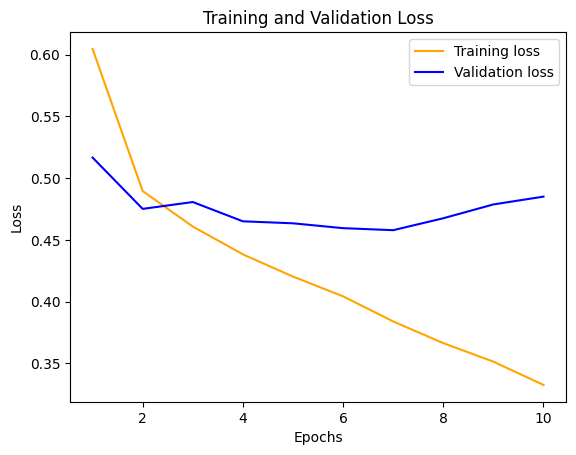

In [32]:
plot_loss(GRU_glove_history)

In [33]:
history.history['accuracy'][3]

0.8121512532234192

In [34]:
history.history['val_accuracy'][3]

0.7978960275650024

In [35]:
history.history['loss'][3]

0.43827611207962036

In [36]:
history.history['val_loss'][3]

0.4650194048881531

## For Epochs = 4

In [46]:
# make our experiments repeatable
np.random.seed(0)

# Model Hyperparameters
embedding_dim = 100

# Here we specify the number of units of our RNN layer
lstm_dims = 196

# Training parameters. Here we specify the training of the net will use N examples for each backprop iteration
batch_size = 64

# We will go thru the entire data set N times
num_epochs = 4

# Prepossessing parameters
# We will only input the first "sequence_length" words of every Yelp review (and pad out with nulls if the text is < "sequence_length
# We will also build our model using the most frequent 20000 words in our tweet 'dictionary'
sequence_length = 200
max_features = 20000

#Specify the number of classes to predict (1 for binary classification or count unique values for multilabel classification)
#num_classes = 1
num_classes = targetVar.nunique()

In [47]:
# encoder = preprocessing.LabelEncoder()
# encoder.fit(targetVar)

X = textVar.values
Y = pd.get_dummies(targetVar).values

In [48]:
train_samples, val_samples, train_labels, val_labels = train_test_split(X,Y, stratify=targetVar, test_size = 0.33, random_state = 0)

In [49]:
# Check how many columns we have, make sure we have our sequence length set correctly

print(train_samples.shape,train_labels.shape)
print(val_samples.shape,val_labels.shape)

(70248,) (70248, 3)
(34601,) (34601, 3)


In [50]:
vectorizer = TextVectorization(max_tokens=max_features, output_sequence_length=sequence_length, ngrams=None, pad_to_max_tokens=True)

text_ds = tf.data.Dataset.from_tensor_slices(train_samples).batch(128)
vectorizer.adapt(text_ds)

In [51]:
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'the', 'i', 'it']

In [52]:
X_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
X_test = vectorizer(np.array([[s] for s in val_samples])).numpy()

Y_train = np.array(train_labels)
Y_test = np.array(val_labels)

In [53]:
embeddings_index = {}

glove_dir = '/home/jupyter/data/wordvec/'
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [54]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [55]:
num_tokens = len(voc) + 2
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 15572 words (4428 misses)


In [56]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [57]:
sequence_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(sequence_input)

x = LSTM(lstm_dims, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(units = 3, activation="softmax")(x)


model = Model(sequence_input, preds)
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 100)         2000200   
                                                                 
 lstm_layer (LSTM)           (None, None, 196)         232848    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 196)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 196)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                9850      
                                                           

In [58]:
filepath="/home/jupyter/data/dl_models/gru_glove_weights_best"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',
                             verbose=1, save_best_only=True, save_weights_only=False, overwrite=True, mode='max')
#only save model if it improves the accuracy

callbacks_list = [checkpoint]

t1 = time.time()
history = model.fit(X_train, Y_train,
                    batch_size=batch_size, 
                    epochs=num_epochs,
                    validation_data=(X_test, Y_test),
                    callbacks = callbacks_list,
                    verbose=1)
t2 = time.time()
print("GRU Glove model train time = %d seconds" %(t2-t1))

GRU_glove_history = history

Epoch 1/4
1097/1098 [============================>.] - ETA: 0s - loss: 0.6099 - accuracy: 0.7255
Epoch 1: val_accuracy improved from -inf to 0.77709, saving model to /home/jupyter/data/dl_models/gru_glove_weights_best


INFO:tensorflow:Assets written to: /home/jupyter/data/dl_models/gru_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/data/dl_models/gru_glove_weights_best/assets


1098/1098 [==============================] - 36s 31ms/step - loss: 0.6098 - accuracy: 0.7255 - val_loss: 0.5026 - val_accuracy: 0.7771
Epoch 2/4
1098/1098 [==============================] - ETA: 0s - loss: 0.4910 - accuracy: 0.7839
Epoch 2: val_accuracy improved from 0.77709 to 0.78853, saving model to /home/jupyter/data/dl_models/gru_glove_weights_best


INFO:tensorflow:Assets written to: /home/jupyter/data/dl_models/gru_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/data/dl_models/gru_glove_weights_best/assets


1098/1098 [==============================] - 36s 33ms/step - loss: 0.4910 - accuracy: 0.7839 - val_loss: 0.4812 - val_accuracy: 0.7885
Epoch 3/4
1095/1098 [============================>.] - ETA: 0s - loss: 0.4616 - accuracy: 0.7984
Epoch 3: val_accuracy improved from 0.78853 to 0.79558, saving model to /home/jupyter/data/dl_models/gru_glove_weights_best


INFO:tensorflow:Assets written to: /home/jupyter/data/dl_models/gru_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/data/dl_models/gru_glove_weights_best/assets


1098/1098 [==============================] - 36s 33ms/step - loss: 0.4615 - accuracy: 0.7984 - val_loss: 0.4706 - val_accuracy: 0.7956
Epoch 4/4
1097/1098 [============================>.] - ETA: 0s - loss: 0.4563 - accuracy: 0.8040
Epoch 4: val_accuracy improved from 0.79558 to 0.80194, saving model to /home/jupyter/data/dl_models/gru_glove_weights_best


INFO:tensorflow:Assets written to: /home/jupyter/data/dl_models/gru_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/data/dl_models/gru_glove_weights_best/assets


1098/1098 [==============================] - 34s 31ms/step - loss: 0.4563 - accuracy: 0.8040 - val_loss: 0.4567 - val_accuracy: 0.8019
GRU Glove model train time = 142 seconds


In [59]:
!ls -l "/home/jupyter/data/dl_models/gru_glove_weights_best"

total 102984
drwxr-xr-x 2 jupyter jupyter      4096 May 22 08:09 assets
-rw-r--r-- 1 jupyter jupyter 104631092 May 24 23:14 keras_metadata.pb
-rw-r--r-- 1 jupyter jupyter    812600 May 24 23:14 saved_model.pb
drwxr-xr-x 2 jupyter jupyter      4096 May 24 23:14 variables


In [60]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [61]:
pred_model = model.predict(X_test)

1082/1082 [==============================] - 5s 4ms/step


In [63]:
pred_model_final = np.argmax(pred_model,axis=1)

In [65]:
Y_test_max = np.argmax(Y_test,axis=1)

In [66]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [67]:
accuracy_score(Y_test_max, pred_model_final)  

0.8019421404005664

In [68]:
print(confusion_matrix(Y_test_max, pred_model_final))

[[ 4727   901   171]
 [ 1220  7297  3060]
 [   95  1406 15724]]


In [69]:
print(classification_report(Y_test_max, pred_model_final))

              precision    recall  f1-score   support

           0       0.78      0.82      0.80      5799
           1       0.76      0.63      0.69     11577
           2       0.83      0.91      0.87     17225

    accuracy                           0.80     34601
   macro avg       0.79      0.79      0.79     34601
weighted avg       0.80      0.80      0.80     34601

